In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

from scipy import stats
from scipy.stats.contingency import association

from sklearn.preprocessing import (
    LabelEncoder, 
    PowerTransformer, 
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    PolynomialFeatures
)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.feature_selection import SelectFromModel, RFE, SelectKBest, mutual_info_classif

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    fbeta_score,
    roc_auc_score, 
    average_precision_score,
    confusion_matrix, 
    classification_report, 
    ConfusionMatrixDisplay, 
    RocCurveDisplay, 
    precision_recall_curve,
)

from yellowbrick.model_selection import (
    ValidationCurve,
    LearningCurve
)

import xgboost
from xgboost import XGBClassifier

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from typing import Any, Dict, Union, Sequence

from loguru import logger
from omegaconf import OmegaConf

pd.set_option('display.max_columns', None)
pd.options.plotting.backend = 'matplotlib'
warnings.filterwarnings('ignore')

In [2]:
def pipe_logger(df, addon_msg=''):
    if addon_msg != '':
        logger.info(addon_msg)
    logger.info(f"Shape of DataFrame: {df.shape[0]} x {df.shape[1]}")
    return df

In [3]:
hotel = pd.read_csv('../../data/raw/hotel_reservations.csv')
hotel

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


In [4]:
(hotel
 .info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [5]:
(hotel
 .describe()
)

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


In [6]:
(hotel
 ['booking_status']
 .value_counts(normalize=True, dropna=False))

booking_status
Not_Canceled    0.672364
Canceled        0.327636
Name: proportion, dtype: float64

In [7]:
def tweak_hotel(df: pd.DataFrame) -> pd.DataFrame:
    
    leap_year_error = (df
                       .loc[(df['arrival_year'] == 2018) & (df['arrival_month'] == 2) & (df['arrival_date'] == 29)]
                       .index)
    return (df
            .pipe(pipe_logger)
            .astype({**{k: 'int8' 
                        for k in ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'required_car_parking_space', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'no_of_special_requests']},
                     **{k: 'int16'
                        for k in ['lead_time']},
                     **{k: 'category'
                        for k in ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type',]},
                     **{k: 'str'
                        for k in ['arrival_date', 'arrival_month', 'arrival_year']},
                     'avg_price_per_room': 'float16'})
            .drop(columns=['Booking_ID'])
            .drop(leap_year_error)
            .pipe(pipe_logger, "After dropping leap year error...")
            )

In [8]:
tweaked_hotel = tweak_hotel(hotel)
tweaked_hotel

2024-03-27 16:54:42.739 | INFO     | __main__:pipe_logger:4 - Shape of DataFrame: 36275 x 19
2024-03-27 16:54:42.765 | INFO     | __main__:pipe_logger:3 - After dropping leap year error...
2024-03-27 16:54:42.766 | INFO     | __main__:pipe_logger:4 - Shape of DataFrame: 36238 x 18


,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.0000,0,Not_Canceled
1,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.6875,1,Not_Canceled
2,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.0000,0,Canceled
3,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.0000,0,Canceled
4,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.5000,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.7500,1,Not_Canceled
36271,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.9375,2,Canceled
36272,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.3750,2,Not_Canceled
36273,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.5000,0,Canceled


In [9]:
X = tweaked_hotel.drop(columns=['booking_status'])
y = tweaked_hotel['booking_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
label_encoder = LabelEncoder()
y_train = (pd
           .DataFrame(label_encoder.fit_transform(y_train), 
                      columns=['booking_status'])
           .astype({'booking_status': 'int8'})
           )

y_test = (pd
          .DataFrame(label_encoder.transform(y_test), 
                     columns=['booking_status'])
          .astype({'booking_status': 'int8'})
          )

In [11]:
class TweakFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
    
        return (X
                .assign(lead_time_category=lambda df_: np.where(df_['lead_time'] < 90, 'Within 3 months', np.where(df_['lead_time'] < 180, 'Within 6 months', 'Beyond 6 months')),
                        is_weekend_arrival=lambda df_: np.where(pd.to_datetime(df_['arrival_year'] + '-' + df_['arrival_month'] + '-' + df_['arrival_date']).dt.weekday > 5, 1, 0),
                        total_people=lambda df_: df_['no_of_adults'] + df_['no_of_children'],
                        is_alone=lambda df_: np.where(df_['total_people'] == 1, 1, 0))
                .astype({'lead_time_category': 'category',
                         'is_weekend_arrival': 'int8',
                         'total_people': 'int8',
                         'is_alone': 'int8',
                         'arrival_year': 'int16',
                         'arrival_month': 'int8', 
                         'arrival_date': 'int8'})
                .drop(columns=['arrival_year'])
                )

In [12]:
TweakFeatures().fit_transform(X_train)

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,lead_time_category,is_weekend_arrival,total_people,is_alone
10409,2,0,0,2,Not Selected,0,Room_Type 1,68,3,11,Online,0,0,0,67.5000,1,Within 3 months,1,2,0
6307,2,1,0,3,Meal Plan 1,0,Room_Type 1,149,7,20,Online,0,0,0,127.5000,0,Within 6 months,0,3,0
19004,2,0,0,3,Meal Plan 1,0,Room_Type 1,72,3,31,Online,0,0,0,67.2500,0,Within 3 months,0,2,0
9609,2,0,0,3,Meal Plan 1,0,Room_Type 1,259,5,5,Offline,0,0,0,90.0000,0,Beyond 6 months,0,2,0
32308,2,0,2,0,Meal Plan 1,1,Room_Type 1,47,12,6,Online,0,0,0,115.1875,1,Within 3 months,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18283,1,0,0,1,Not Selected,0,Room_Type 1,0,8,20,Online,0,0,0,92.1875,0,Within 3 months,0,1,1
7308,2,0,0,1,Not Selected,0,Room_Type 1,143,8,20,Online,0,0,0,94.5000,0,Within 6 months,0,2,0
22902,1,0,3,7,Meal Plan 1,0,Room_Type 1,29,4,15,Online,0,0,0,99.5000,1,Within 3 months,1,1,1
20224,2,1,1,3,Meal Plan 1,0,Room_Type 1,83,8,1,Online,0,0,0,135.8750,1,Within 3 months,0,3,0


In [13]:
ohe_categorical_features = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'lead_time_category']
ohe_categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first').set_output(transform='pandas'))
])

standard_numerical_features = ['lead_time', 'avg_price_per_room']
standard_numerical_transformer = Pipeline(steps=[
    ('scale', StandardScaler().set_output(transform='pandas'))
])

poly = PolynomialFeatures(interaction_only=False).set_output(transform='pandas')

# sel_ = SelectFromModel(LogisticRegression(solver= 'liblinear', C=1, penalty='l1', random_state=42), max_features=12).set_output(transform='pandas')
sel_ = SelectFromModel(RandomForestClassifier(n_estimators=100, max_depth=5, max_features='sqrt', n_jobs=-1, random_state=42), max_features=10).set_output(transform='pandas')
# sel_ = RFE(LogisticRegression(solver= 'liblinear', C=1, penalty='l1', random_state=42), n_features_to_select=10).set_output(transform='pandas')
# sel_ = SelectKBest(mutual_info_classif, k=10).set_output(transform='pandas')

col_trans = ColumnTransformer(
    transformers=[
        ('ohe_categorical_features', ohe_categorical_transformer, ohe_categorical_features),
        ('standard_numerical_features', standard_numerical_transformer, standard_numerical_features)
    ],
    remainder='passthrough', 
    verbose=0, 
    verbose_feature_names_out=False).set_output(transform='pandas')

In [14]:
pipeline_oob_xgb = Pipeline(steps = [
       ('tweak_features', TweakFeatures()),
       ('col_trans', col_trans),
    #    ('poly', poly),
       ('select', sel_),
])

In [15]:
X_train_transformed = pipeline_oob_xgb.fit_transform(X_train, y_train.values.ravel())
X_train_transformed

,market_segment_type_Online,lead_time_category_Within 3 months,lead_time_category_Within 6 months,lead_time,avg_price_per_room,no_of_special_requests
10409,1.0,1.0,0.0,-0.201827,-1.018437,1
6307,1.0,0.0,1.0,0.738327,0.681051,0
19004,1.0,1.0,0.0,-0.155400,-1.025518,0
9609,0.0,0.0,0.0,2.015079,-0.381129,0
32308,1.0,1.0,0.0,-0.445571,0.332302,1
...,...,...,...,...,...,...
18283,1.0,1.0,0.0,-0.991092,-0.319168,0
7308,1.0,0.0,1.0,0.668686,-0.253667,0
22902,1.0,1.0,0.0,-0.654494,-0.112043,1
20224,1.0,1.0,0.0,-0.027725,0.918271,1


In [16]:
xg_oob = XGBClassifier(n_estimators=500,
                       early_stopping_rounds=50,
                       eval_metric=['logloss'],
                       seed=4)

xg_oob.fit(pipeline_oob_xgb.fit_transform(X_train, y_train),
           y_train, 
           eval_set=[(pipeline_oob_xgb.transform(X_train), y_train),
                     (pipeline_oob_xgb.transform(X_test), y_test)
                    ],
           verbose=25,
          )

print("Model Accuracy = ", xg_oob.score(pipeline_oob_xgb.transform(X_test), y_test))

[0]	validation_0-logloss:0.55998	validation_1-logloss:0.56117
[25]	validation_0-logloss:0.32214	validation_1-logloss:0.33752
[50]	validation_0-logloss:0.29412	validation_1-logloss:0.32158
[75]	validation_0-logloss:0.27507	validation_1-logloss:0.31220
[100]	validation_0-logloss:0.26111	validation_1-logloss:0.30932
[125]	validation_0-logloss:0.24846	validation_1-logloss:0.30782
[150]	validation_0-logloss:0.24094	validation_1-logloss:0.30606
[175]	validation_0-logloss:0.23296	validation_1-logloss:0.30584
[200]	validation_0-logloss:0.22525	validation_1-logloss:0.30487
[225]	validation_0-logloss:0.21867	validation_1-logloss:0.30515
[250]	validation_0-logloss:0.21255	validation_1-logloss:0.30588
[254]	validation_0-logloss:0.21174	validation_1-logloss:0.30606
Model Accuracy =  0.8700331125827815


In [17]:
xg_oob.best_ntree_limit

206

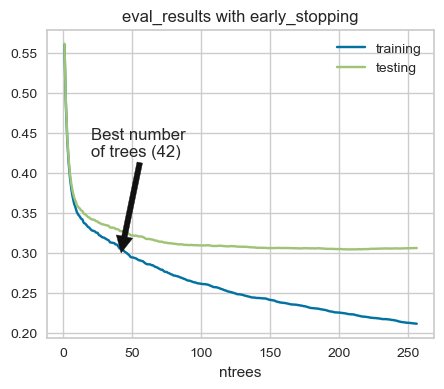

In [18]:
results = xg_oob.evals_result()
fig, ax = plt.subplots(figsize=(8,4))
ax = (pd.DataFrame({'training': results['validation_0']['logloss'],
                    'testing': results['validation_1']['logloss']})
        .assign(ntrees=lambda adf: range(1, len(adf)+1))
        .set_index('ntrees')
        .plot(figsize=(5,4), ax=ax, title='eval_results with early_stopping')
     )

ax.annotate('Best number \nof trees (42)', xy=(42, .3),
           xytext=(20,.42), arrowprops={'color':'k'})
ax.set_xlabel('ntrees');

In [19]:
y_pred = xg_oob.predict(pipeline_oob_xgb.transform(X_test))
y_pred

array([0, 1, 1, ..., 1, 1, 0])

In [20]:
print(classification_report(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred)))

              precision    recall  f1-score   support

    Canceled       0.83      0.76      0.79      2376
Not_Canceled       0.89      0.92      0.91      4872

    accuracy                           0.87      7248
   macro avg       0.86      0.84      0.85      7248
weighted avg       0.87      0.87      0.87      7248



In [21]:
precision = precision_score(y_pred, y_test.values.ravel())
recall = recall_score(y_pred, y_test.values.ravel())
f1 = f1_score(y_pred, y_test.values.ravel())
accuracy = accuracy_score(y_pred, y_test.values.ravel())

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'Accuracy: {accuracy:.2f}')

Precision: 0.92
Recall: 0.89
F1-Score: 0.91
Accuracy: 0.87


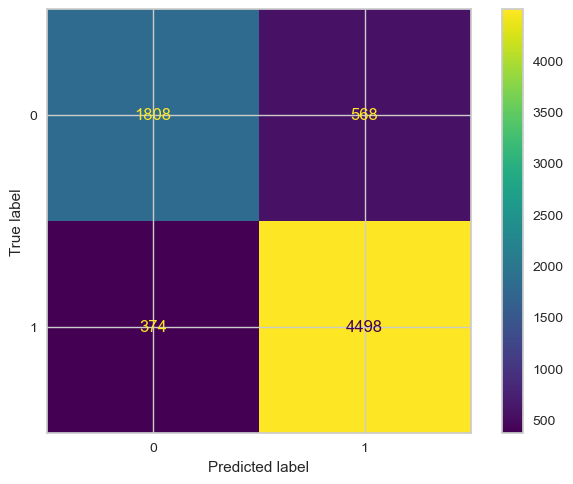

In [22]:
ConfusionMatrixDisplay(confusion_matrix(y_test.values.ravel(), y_pred)).plot();

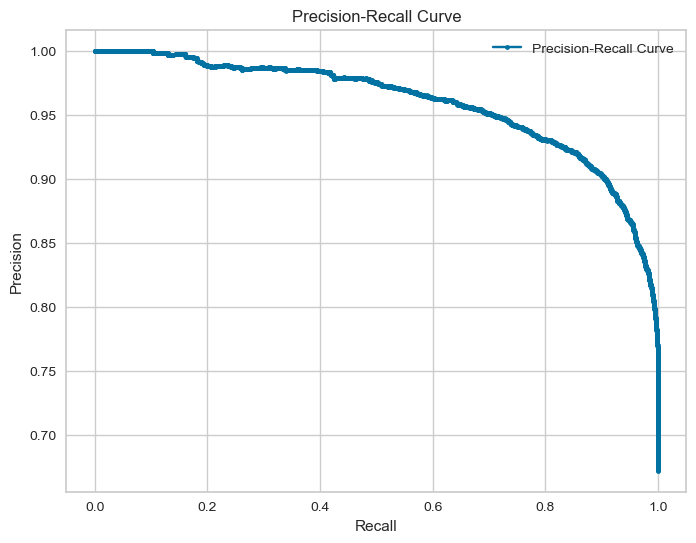

In [23]:
precision, recall, thresholds = precision_recall_curve(y_test.values.ravel(), xg_oob.predict_proba(pipeline_oob_xgb.transform(X_test))[:,1])
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()

In [24]:
def hyperparameter_tuning(space: Dict[str, Union[float, int]],
                          X_train: pd.DataFrame, 
                          y_train: pd.Series,
                          X_test: pd.DataFrame,
                          y_test: pd.Series,
                          early_stopping_rounds: int=50,
                          metric:callable=fbeta_score) -> Dict[str, Any]:
    
    int_vals = ['max_depth']
    space = {k: (int (val) if k in int_vals else val)
             for k, val in space.items()}
    space['early_stopping_rounds'] = early_stopping_rounds
    
    model = XGBClassifier(**space, 
                          eval_metric=['aucpr'], #logloss
                          seed=42,
                          n_jobs=-1)
    
    model.fit(X_train, 
              y_train, 
              eval_set=[(X_train, y_train),
                        (X_test, y_test)],
              verbose=False)
    
    pred = model.predict(X_test)
    score = metric(y_test, pred, beta=1.5)
    
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

In [25]:
@scope.define
def to_int(x):
    return int(x)

In [26]:
options = {'n_estimators': hp.choice('n_estimators', [100, 250]),
           'max_depth': scope.to_int(hp.quniform('max_depth', 3, 12, 1)),
           'min_child_weight': hp.loguniform('min_child_weight', -1, 1),
           'subsample': hp.uniform('subsample', 0.5, 1),
           'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
           'reg_alpha': hp.uniform('reg_alpha', 0, 100),
           'reg_lambda': hp.uniform('reg_lambda', 1, 100),
           'gamma': hp.loguniform('gamma', -10, 10),
           'learning_rate': hp.loguniform('learning_rate', -7, 0),
           # 'scale_pos_weight': hp.choice('scale_pos_weight', [np.sum(y_train) / len(y_train)]),
           # 'max_delta_step': hp.uniform('max_delta_step', 1, 10),
           'random_state': 42
          }

In [28]:
trials = Trials()
SEED=101

xgb_best_params = fmin(fn=lambda space: hyperparameter_tuning(space, 
                                                              X_train_transformed, 
                                                              y_train,
                                                              pipeline_oob_xgb.transform(X_test),
                                                              y_test),
                       space=options,
                       algo=tpe.suggest,
                       max_evals=100,
                       trials=trials,
                       rstate=np.random.default_rng(SEED))

100%|██████████| 100/100 [01:11<00:00,  1.40trial/s, best loss: -0.9086042235140586]


In [29]:
xgb_best_params

{'colsample_bytree': 0.6486155254194931,
 'gamma': 0.0018793573443312039,
 'learning_rate': 0.005224635404307403,
 'max_depth': 11.0,
 'min_child_weight': 2.6656669434041973,
 'n_estimators': 0,
 'reg_alpha': 0.41292865993610706,
 'reg_lambda': 60.96182299279198,
 'subsample': 0.9985858593372575}

In [30]:
xgb_best_params = {
    'n_estimators': [100, 250, 500][xgb_best_params['n_estimators']],
    'colsample_bytree': xgb_best_params['colsample_bytree'],
    'gamma': xgb_best_params['gamma'],
    'learning_rate': xgb_best_params['learning_rate'],
    'max_depth': int(xgb_best_params['max_depth']),
    'min_child_weight': xgb_best_params['min_child_weight'],
    'reg_alpha': xgb_best_params['reg_alpha'],
    'reg_lambda': xgb_best_params['reg_lambda'],
    # 'scale_pos_weight': [np.sum(y_train) / len(y_train)][xgb_best_params['scale_pos_weight']],
    # 'max_delta_step': xgb_best_params['max_delta_step'],
    'subsample': xgb_best_params['subsample']
}

In [31]:
xgb_best_params

{'n_estimators': 100,
 'colsample_bytree': 0.6486155254194931,
 'gamma': 0.0018793573443312039,
 'learning_rate': 0.005224635404307403,
 'max_depth': 11,
 'min_child_weight': 2.6656669434041973,
 'reg_alpha': 0.41292865993610706,
 'reg_lambda': 60.96182299279198,
 'subsample': 0.9985858593372575}

In [33]:
xgb_clf_tuned = XGBClassifier(**xgb_best_params, 
                              objective='binary:logistic', 
                              seed=42)

xgb_clf_tuned.fit(X_train_transformed, y_train)
y_pred = xgb_clf_tuned.predict(pipeline_oob_xgb.transform(X_test))

In [34]:
print(f'Accuracy score: {accuracy_score(y_test, xgb_clf_tuned.predict(pipeline_oob_xgb.transform(X_test)))}')
print(f'Precision score: {precision_score(y_test, xgb_clf_tuned.predict(pipeline_oob_xgb.transform(X_test)))}')
print(f'Recall score: {recall_score(y_test, xgb_clf_tuned.predict(pipeline_oob_xgb.transform(X_test)))}')
print(f'F1 score: {f1_score(y_test, xgb_clf_tuned.predict(pipeline_oob_xgb.transform(X_test)))}')
print(f'ROC-AUC score: {roc_auc_score(y_test, xgb_clf_tuned.predict_proba(pipeline_oob_xgb.transform(X_test))[:, 1])}')
print(f'Average Precision Score: {average_precision_score(y_test, xgb_clf_tuned.predict_proba(pipeline_oob_xgb.transform(X_test))[:, 1])}')

Accuracy score: 0.8096026490066225
Precision score: 0.798972602739726
Recall score: 0.9577175697865353
F1 score: 0.8711725168035848
ROC-AUC score: 0.868490339215914
Average Precision Score: 0.9199899686083998


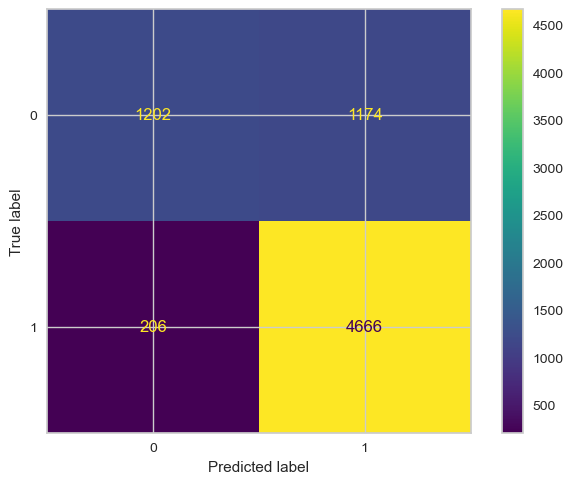

In [35]:
ConfusionMatrixDisplay(confusion_matrix(y_test, xgb_clf_tuned.predict(pipeline_oob_xgb.transform(X_test)))).plot();

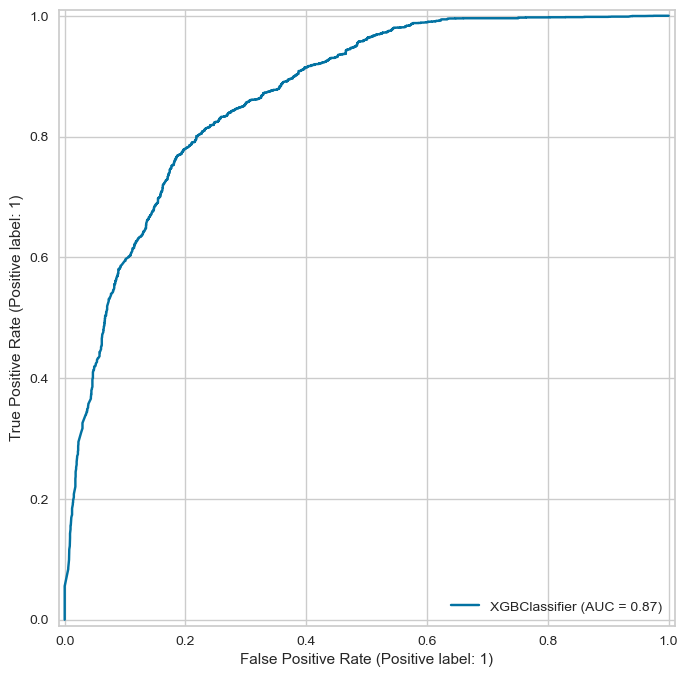

In [36]:
fig, ax = plt.subplots(figsize=(8,8))
RocCurveDisplay.from_estimator(xgb_clf_tuned,
                               pipeline_oob_xgb.transform(X_test),
                               y_test,
                               ax=ax,);

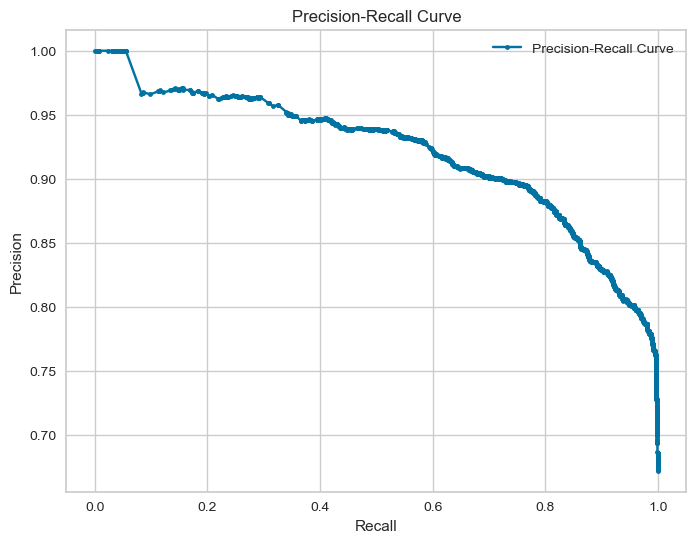

In [37]:
precision, recall, thresholds = precision_recall_curve(y_test, xgb_clf_tuned.predict_proba(pipeline_oob_xgb.transform(X_test))[:,1])
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()

In [39]:
print("CV=5 Mean Accuracy = ", cross_val_score(xgb_clf_tuned,
                                               # pipeline_oob_xgb.transform(X_train),
                                               X_train_transformed,
                                               y=y_train,
                                               scoring='accuracy',
                                               cv=5,
                                               n_jobs=-1).mean())

CV=5 Mean Accuracy =  0.8089686098654709
